<a href="https://colab.research.google.com/github/pbcquoc/transformer/blob/master/transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! pip -q install torchtext==0.6.0
! pip -q install pyvi
! pip -q install sentencepiece

import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [38]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import os
import math

In [4]:
class Embedder(nn.Module):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model

        self.embed = nn.Embedding(vocab_size, d_model)

    def forward(self, x):
        return self.embed(x)

# Embedder(100, 512)(torch.LongTensor([1,2,3,4])).shape

In [5]:
class PositionalEncoder(nn.Module):
    def __init__(self, d_model, max_seq_length=512, dropout=0.1):
        super().__init__()

        self.d_model = d_model
        self.dropout = nn.Dropout(dropout)

        pe = torch.zeros(max_seq_length, d_model)

        # Bảng pe mình vẽ ở trên
        for pos in range(max_seq_length):
            for i in range(0, d_model, 2):
                pe[pos, i] = math.sin(pos/(10000**(2*i/d_model)))
                pe[pos, i+1] = math.cos(pos/(10000**((2*i+1)/d_model)))
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):

        x = x*math.sqrt(self.d_model)
        seq_length = x.size(1)

        pe = Variable(self.pe[:, :seq_length], requires_grad=False)

        if x.is_cuda:
            pe.cuda()
        # cộng embedding vector với pe
        x = x + pe
        x = self.dropout(x)

        return x

# PositionalEncoder(512)(torch.rand(5, 30, 512)).shape

In [6]:
def attention(q, k, v, mask=None, dropout=None):
    """
    q: batch_size x head x seq_length x d_model
    k: batch_size x head x seq_length x d_model
    v: batch_size x head x seq_length x d_model
    mask: batch_size x 1 x 1 x seq_length
    output: batch_size x head x seq_length x d_model
    """

    # attention score được tính bằng cách nhân q với k
    d_k = q.size(-1)
    scores = torch.matmul(q, k.transpose(-2, -1))/math.sqrt(d_k)

    if mask is not None:
        mask = mask.unsqueeze(1)
        scores = scores.masked_fill(mask==0, -1e9)
    # xong rồi thì chuẩn hóa bằng softmax
    scores = F.softmax(scores, dim=-1)

    if dropout is not None:
        scores = dropout(scores)

    output = torch.matmul(scores, v)
    return output, scores

# attention(torch.rand(32, 8, 30, 512), torch.rand(32, 8, 30, 512), torch.rand(32, 8, 30, 512)).shape

In [7]:
class MultiHeadAttention(nn.Module):
    def __init__(self, heads, d_model, dropout=0.1):
        super().__init__()
        assert d_model % heads == 0

        self.d_model = d_model
        self.d_k = d_model//heads
        self.h = heads
        self.attn = None

        # tạo ra 3 ma trận trọng số là q_linear, k_linear, v_linear như hình trên
        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(d_model, d_model)

    def forward(self, q, k, v, mask=None):
        """
        q: batch_size x seq_length x d_model
        k: batch_size x seq_length x d_model
        v: batch_size x seq_length x d_model
        mask: batch_size x 1 x seq_length
        output: batch_size x seq_length x d_model
        """
        bs = q.size(0)
        # nhân ma trận trọng số q_linear, k_linear, v_linear với dữ liệu đầu vào q, k, v
        # ở bước encode các bạn lưu ý rằng q, k, v chỉ là một (xem hình trên)
        q = self.q_linear(q).view(bs, -1, self.h, self.d_k)
        k = self.k_linear(k).view(bs, -1, self.h, self.d_k)
        v = self.v_linear(v).view(bs, -1, self.h, self.d_k)

        q = q.transpose(1, 2)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)

        # tính attention score
        scores, self.attn = attention(q, k, v, mask, self.dropout)

        concat = scores.transpose(1, 2).contiguous().view(bs, -1, self.d_model)

        output = self.out(concat)
        return output

# MultiHeadAttention(8, 512)(torch.rand(32, 30, 512), torch.rand(32, 30, 512), torch.rand(32, 30, 512)).shape

In [8]:
class Norm(nn.Module):
    def __init__(self, d_model, eps = 1e-6):
        super().__init__()

        self.size = d_model

        # create two learnable parameters to calibrate normalisation
        self.alpha = nn.Parameter(torch.ones(self.size))
        self.bias = nn.Parameter(torch.zeros(self.size))

        self.eps = eps

    def forward(self, x):
        norm = self.alpha * (x - x.mean(dim=-1, keepdim=True)) \
        / (x.std(dim=-1, keepdim=True) + self.eps) + self.bias
        return norm

In [9]:
class FeedForward(nn.Module):
    """ Trong kiến trúc của chúng ta có tầng linear
    """
    def __init__(self, d_model, d_ff=2048, dropout = 0.1):
        super().__init__()

        # We set d_ff as a default to 2048
        self.linear_1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        x = self.dropout(F.relu(self.linear_1(x)))
        x = self.linear_2(x)
        return x

In [10]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout=0.1):
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.norm_2 = Norm(d_model)
        self.attn = MultiHeadAttention(heads, d_model, dropout=dropout)
        self.ff = FeedForward(d_model, dropout=dropout)
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)

    def forward(self, x, mask):
        """
        x: batch_size x seq_length x d_model
        mask: batch_size x 1 x seq_length
        output: batch_size x seq_length x d_model
        """


        x2 = self.norm_1(x)
        # tính attention value, các bạn để ý q, k, v là giống nhau
        x = x + self.dropout_1(self.attn(x2,x2,x2,mask))
        x2 = self.norm_2(x)
        x = x + self.dropout_2(self.ff(x2))
        return x

# EncoderLayer(512, 8)(torch.rand(32, 30, 512), torch.rand(32 , 1, 30)).shape

In [11]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout=0.1):
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.norm_2 = Norm(d_model)
        self.norm_3 = Norm(d_model)

        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
        self.dropout_3 = nn.Dropout(dropout)

        self.attn_1 = MultiHeadAttention(heads, d_model, dropout=dropout)
        self.attn_2 = MultiHeadAttention(heads, d_model, dropout=dropout)
        self.ff = FeedForward(d_model, dropout=dropout)

    def forward(self, x, e_outputs, src_mask, trg_mask):
        """
        x: batch_size x seq_length x d_model
        e_outputs: batch_size x seq_length x d_model
        src_mask: batch_size x 1 x seq_length
        trg_mask: batch_size x 1 x seq_length
        """
        # Các bạn xem hình trên, kiến trúc mình vẽ với code ở chỗ này tương đương nhau.
        x2 = self.norm_1(x)
        # multihead attention thứ nhất, chú ý các từ ở target
        x = x + self.dropout_1(self.attn_1(x2, x2, x2, trg_mask))
        x2 = self.norm_2(x)
        # masked mulithead attention thứ 2. k, v là giá trị output của mô hình encoder
        x = x + self.dropout_2(self.attn_2(x2, e_outputs, e_outputs, src_mask))
        x2 = self.norm_3(x)
        x = x + self.dropout_3(self.ff(x2))
        return x

# DecoderLayer(512, 8)(torch.rand(32, 30, 512), torch.rand(32, 30, 512), torch.rand(32, 1, 30), torch.rand(32, 1, 30)).shape

In [12]:
import copy

def get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

class Encoder(nn.Module):
    """Một encoder có nhiều encoder layer nhé !!!
    """
    def __init__(self, vocab_size, d_model, N, heads, dropout):
        super().__init__()
        self.N = N
        self.embed = Embedder(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model, dropout=dropout)
        self.layers = get_clones(EncoderLayer(d_model, heads, dropout), N)
        self.norm = Norm(d_model)

    def forward(self, src, mask):
        """
        src: batch_size x seq_length
        mask: batch_size x 1 x seq_length
        output: batch_size x seq_length x d_model
        """
        x = self.embed(src)
        x = self.pe(x)
        for i in range(self.N):
            x = self.layers[i](x, mask)
        return self.norm(x)

# Encoder(232, 512,6,8,0.1)(torch.LongTensor(32, 30).random_(0, 10), torch.rand(32, 1, 30)).shape

In [13]:
class Decoder(nn.Module):
    """Một decoder có nhiều decoder layer nhé !!!
    """
    def __init__(self, vocab_size, d_model, N, heads, dropout):
        super().__init__()
        self.N = N
        self.embed = Embedder(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model, dropout=dropout)
        self.layers = get_clones(DecoderLayer(d_model, heads, dropout), N)
        self.norm = Norm(d_model)
    def forward(self, trg, e_outputs, src_mask, trg_mask):
        """
        trg: batch_size x seq_length
        e_outputs: batch_size x seq_length x d_model
        src_mask: batch_size x 1 x seq_length
        trg_mask: batch_size x 1 x seq_length
        output: batch_size x seq_length x d_model
        """
        x = self.embed(trg)
        x = self.pe(x)
        for i in range(self.N):
            x = self.layers[i](x, e_outputs, src_mask, trg_mask)
        return self.norm(x)

# Decoder(232, 512, 6, 8, 0.1)(torch.LongTensor(32, 30).random_(0, 10), torch.rand(32, 30, 512), torch.rand(32, 1, 30), torch.rand(32, 1, 30)).shape

In [14]:
class Transformer(nn.Module):
    """ Cuối cùng ghép chúng lại với nhau để được mô hình transformer hoàn chỉnh
    """
    def __init__(self, src_vocab, trg_vocab, d_model, N, heads, dropout):
        super().__init__()
        self.encoder = Encoder(src_vocab, d_model, N, heads, dropout)
        self.decoder = Decoder(trg_vocab, d_model, N, heads, dropout)
        self.out = nn.Linear(d_model, trg_vocab)
    def forward(self, src, trg, src_mask, trg_mask):
        """
        src: batch_size x seq_length
        trg: batch_size x seq_length
        src_mask: batch_size x 1 x seq_length
        trg_mask batch_size x 1 x seq_length
        output: batch_size x seq_length x vocab_size
        """
        e_outputs = self.encoder(src, src_mask)

        d_output = self.decoder(trg, e_outputs, src_mask, trg_mask)
        output = self.out(d_output)
        return output

# Transformer(232, 232, 512, 6, 8, 0.1)(torch.LongTensor(32, 30).random_(0, 10), torch.LongTensor(32, 30).random_(0, 10),torch.rand(32, 1, 30),torch.rand(32, 1, 30)).shape

In [15]:
from torchtext import data

class MyIterator(data.Iterator):
    def create_batches(self):
        if self.train:
            def pool(d, random_shuffler):
                for p in data.batch(d, self.batch_size * 100):
                    p_batch = data.batch(
                        sorted(p, key=self.sort_key),
                        self.batch_size, self.batch_size_fn)
                    for b in random_shuffler(list(p_batch)):
                        yield b
            self.batches = pool(self.data(), self.random_shuffler)

        else:
            self.batches = []
            for b in data.batch(self.data(), self.batch_size,
                                          self.batch_size_fn):
                self.batches.append(sorted(b, key=self.sort_key))

global max_src_in_batch, max_tgt_in_batch

def batch_size_fn(new, count, sofar):
    "Keep augmenting batch and calculate total number of tokens + padding."
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch,  len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch,  len(new.trg) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    return max(src_elements, tgt_elements)

In [16]:

def nopeak_mask(size, device):
    """Tạo mask được sử dụng trong decoder để lúc dự đoán trong quá trình huấn luyện
     mô hình không nhìn thấy được các từ ở tương lai
    """
    np_mask = np.triu(np.ones((1, size, size)),
    k=1).astype('uint8')
    np_mask =  Variable(torch.from_numpy(np_mask) == 0)
    np_mask = np_mask.to(device)

    return np_mask

def create_masks(src, trg, src_pad, trg_pad, device):
    """ Tạo mask cho encoder,
    để mô hình không bỏ qua thông tin của các kí tự PAD do chúng ta thêm vào
    """
    src_mask = (src != src_pad).unsqueeze(-2)

    if trg is not None:
        trg_mask = (trg != trg_pad).unsqueeze(-2)
        size = trg.size(1) # get seq_len for matrix
        np_mask = nopeak_mask(size, device)
        if trg.is_cuda:
            np_mask.cuda()
        trg_mask = trg_mask & np_mask

    else:
        trg_mask = None
    return src_mask, trg_mask

In [17]:
from nltk.corpus import wordnet
import re

def get_synonym(word, SRC):
    syns = wordnet.synsets(word)
    for s in syns:
        for l in s.lemmas():
            if SRC.vocab.stoi[l.name()] != 0:
                return SRC.vocab.stoi[l.name()]

    return 0

def multiple_replace(dict, text):
  # Create a regular expression  from the dictionary keys
  regex = re.compile("(%s)" % "|".join(map(re.escape, dict.keys())))

  # For each match, look-up corresponding value in dictionary
  return regex.sub(lambda mo: dict[mo.string[mo.start():mo.end()]], text)

In [18]:
def init_vars(src, model, SRC, TRG, device, k, max_len):
    """ Tính toán các ma trận cần thiết trong quá trình translation sau khi mô hình học xong
    """
    init_tok = TRG.vocab.stoi['<sos>']
    src_mask = (src != SRC.vocab.stoi['<pad>']).unsqueeze(-2)

    # tính sẵn output của encoder
    e_output = model.encoder(src, src_mask)

    outputs = torch.LongTensor([[init_tok]])

    outputs = outputs.to(device)

    trg_mask = nopeak_mask(1, device)
    # dự đoán kí tự đầu tiên
    out = model.out(model.decoder(outputs,
    e_output, src_mask, trg_mask))
    out = F.softmax(out, dim=-1)

    probs, ix = out[:, -1].data.topk(k)
    log_scores = torch.Tensor([math.log(prob) for prob in probs.data[0]]).unsqueeze(0)

    outputs = torch.zeros(k, max_len).long()
    outputs = outputs.to(device)
    outputs[:, 0] = init_tok
    outputs[:, 1] = ix[0]

    e_outputs = torch.zeros(k, e_output.size(-2),e_output.size(-1))

    e_outputs = e_outputs.to(device)
    e_outputs[:, :] = e_output[0]

    return outputs, e_outputs, log_scores

def k_best_outputs(outputs, out, log_scores, i, k):

    probs, ix = out[:, -1].data.topk(k)
    log_probs = torch.Tensor([math.log(p) for p in probs.data.view(-1)]).view(k, -1) + log_scores.transpose(0,1)
    k_probs, k_ix = log_probs.view(-1).topk(k)

    row = k_ix // k
    col = k_ix % k

    outputs[:, :i] = outputs[row, :i]
    outputs[:, i] = ix[row, col]

    log_scores = k_probs.unsqueeze(0)

    return outputs, log_scores

def beam_search(src, model, SRC, TRG, device, k, max_len):

    outputs, e_outputs, log_scores = init_vars(src, model, SRC, TRG, device, k, max_len)
    eos_tok = TRG.vocab.stoi['<eos>']
    src_mask = (src != SRC.vocab.stoi['<pad>']).unsqueeze(-2)
    ind = None
    for i in range(2, max_len):

        trg_mask = nopeak_mask(i, device)

        out = model.out(model.decoder(outputs[:,:i],
        e_outputs, src_mask, trg_mask))

        out = F.softmax(out, dim=-1)

        outputs, log_scores = k_best_outputs(outputs, out, log_scores, i, k)

        ones = (outputs==eos_tok).nonzero() # Occurrences of end symbols for all input sentences.
        sentence_lengths = torch.zeros(len(outputs), dtype=torch.long).cuda()
        for vec in ones:
            i = vec[0]
            if sentence_lengths[i]==0: # First end symbol has not been found yet
                sentence_lengths[i] = vec[1] # Position of first end symbol

        num_finished_sentences = len([s for s in sentence_lengths if s > 0])

        if num_finished_sentences == k:
            alpha = 0.7
            div = 1/(sentence_lengths.type_as(log_scores)**alpha)
            _, ind = torch.max(log_scores * div, 1)
            ind = ind.data[0]
            break

    if ind is None:

        length = (outputs[0]==eos_tok).nonzero()[0] if len((outputs[0]==eos_tok).nonzero()) > 0 else -1
        return ' '.join([TRG.vocab.itos[tok] for tok in outputs[0][1:length]])

    else:
        length = (outputs[ind]==eos_tok).nonzero()[0]
        return ' '.join([TRG.vocab.itos[tok] for tok in outputs[ind][1:length]])

In [18]:
# def translate_sentence(sentence, model, SRC, TRG, device, k, max_len):
#     """Dịch một câu sử dụng beamsearch
#     """
#     model.eval()
#     indexed = []
#     sentence = SRC.preprocess(sentence)

#     for tok in sentence:
#         if SRC.vocab.stoi[tok] != SRC.vocab.stoi['<eos>']:
#             indexed.append(SRC.vocab.stoi[tok])
#         else:
#             indexed.append(get_synonym(tok, SRC))

#     sentence = Variable(torch.LongTensor([indexed]))

#     sentence = sentence.to(device)

#     sentence = beam_search(sentence, model, SRC, TRG, device, k, max_len)

#     return  multiple_replace({' ?' : '?',' !':'!',' .':'.','\' ':'\'',' ,':','}, sentence)

In [19]:
import os
import re
import pandas as pd
import sentencepiece as spm
from torchtext import data
from torchtext.data.metrics import bleu_score

def clean_text(sentence: str) -> str:
    sentence = re.sub(r"[\*\"“”\n\\…\+\-\/\=\(\)‘•:\[\]\|’\!;]", " ", str(sentence))
    sentence = re.sub(r"[ ]+", " ", sentence)
    sentence = re.sub(r"\!+", "!", sentence)
    sentence = re.sub(r"\,+", ",", sentence)
    sentence = re.sub(r"\?+", "?", sentence)
    sentence = sentence.lower()
    return sentence.strip()

def read_data(src_file, trg_file):
    src_data = open(src_file, encoding="utf-8").read().strip().split('\n')
    trg_data = open(trg_file, encoding="utf-8").read().strip().split('\n')
    return src_data, trg_data


def train_spm_bpe_from_lines(lines, model_prefix, vocab_size=16000,
                            character_coverage=1.0, user_defined_symbols=None):
    tmp = f"{model_prefix}_corpus.txt"
    with open(tmp, "w", encoding="utf-8") as f:
        for s in lines:
            f.write(clean_text(s) + "\n")   # ✅ train on cleaned text

    uds = user_defined_symbols or []
    uds_arg = ",".join(uds) if uds else ""

    spm.SentencePieceTrainer.Train(
        input=tmp,
        model_prefix=model_prefix,
        vocab_size=vocab_size,
        model_type="bpe",
        character_coverage=character_coverage,
        unk_id=0,
        pad_id=-1,
        bos_id=-1,
        eos_id=-1,
        user_defined_symbols=uds_arg if uds_arg else None
    )
    os.remove(tmp)

class tokenize(object):
    def __init__(self, model_file):
        self.sp = spm.SentencePieceProcessor(model_file=model_file)

    def tokenizer(self, sentence):
        sentence = clean_text(sentence)
        return self.sp.encode(sentence, out_type=str)

    def detokenize(self, pieces):
        return self.sp.decode(pieces)

def create_fields(src_lang, trg_lang,
                  src_model_file="spm_src_bpe.model",
                  trg_model_file="spm_trg_bpe.model"):
    print("loading sentencepiece BPE tokenizers (with cleaning)...")

    t_src = tokenize(src_model_file)
    t_trg = tokenize(trg_model_file)

    SRC = data.Field(
        lower=False,
        tokenize=t_src.tokenizer,
        pad_token="<pad>",
        unk_token="<unk>"
    )

    TRG = data.Field(
        lower=False,
        tokenize=t_trg.tokenizer,
        init_token="<sos>",
        eos_token="<eos>",
        pad_token="<pad>",
        unk_token="<unk>"
    )

    return SRC, TRG, t_src, t_trg

def create_dataset(src_data, trg_data, max_strlen, batchsize, device, SRC, TRG, istrain=True):
    print("creating dataset and iterator... ")

    raw_data = {'src': [line for line in src_data], 'trg': [line for line in trg_data]}
    df = pd.DataFrame(raw_data, columns=["src", "trg"])

    # ✅ lọc đúng theo số token sau preprocess (clean + sentencepiece)
    mask = (
        df['src'].apply(lambda s: len(SRC.preprocess(s)) < max_strlen) &
        df['trg'].apply(lambda s: len(TRG.preprocess(s)) < max_strlen)
    )
    df = df.loc[mask]

    df.to_csv("translate_transformer_temp.csv", index=False)

    data_fields = [('src', SRC), ('trg', TRG)]
    ds = data.TabularDataset('./translate_transformer_temp.csv', format='csv', fields=data_fields)

    it = MyIterator(
        ds, batch_size=batchsize, device=device,
        repeat=False, sort_key=lambda x: (len(x.src), len(x.trg)),
        batch_size_fn=batch_size_fn, train=istrain, shuffle=True
    )

    os.remove('translate_transformer_temp.csv')

    if istrain:
        SRC.build_vocab(ds)
        TRG.build_vocab(ds)

    return it

def translate_sentence(sentence, model, SRC, TRG, device, k, max_len, sp_trg):
    model.eval()

    src_tokens = SRC.preprocess(sentence)  # clean + sp encode
    unk = SRC.vocab.stoi.get("<unk>", 0)
    src_ids = [SRC.vocab.stoi.get(tok, unk) for tok in src_tokens]
    src_tensor = torch.LongTensor([src_ids]).to(device)

    pred_pieces_str = beam_search(src_tensor, model, SRC, TRG, device, k, max_len)
    pieces = pred_pieces_str.split()
    pred_text = sp_trg.detokenize(pieces)
    return pred_text


In [20]:
def step(model, optimizer,batch, criterion):
    """
    Một lần cập nhật mô hình
    """
    model.train()

    src = batch.src.transpose(0,1).cuda()
    trg = batch.trg.transpose(0,1).cuda()
    trg_input = trg[:, :-1]
    src_mask, trg_mask = create_masks(src, trg_input, src_pad, trg_pad, opt['device'])
    preds = model(src, trg_input, src_mask, trg_mask)

    ys = trg[:, 1:].contiguous().view(-1)

    optimizer.zero_grad()
    loss = criterion(preds.view(-1, preds.size(-1)), ys)
    loss.backward()
    optimizer.step_and_update_lr()

    loss = loss.item()

    return loss

In [21]:
def validiate(model, valid_iter, criterion):
    """ Tính loss trên tập validation
    """
    model.eval()

    with torch.no_grad():
        total_loss = []
        for batch in valid_iter:
            src = batch.src.transpose(0,1).cuda()
            trg = batch.trg.transpose(0,1).cuda()
            trg_input = trg[:, :-1]
            src_mask, trg_mask = create_masks(src, trg_input, src_pad, trg_pad, opt['device'])
            preds = model(src, trg_input, src_mask, trg_mask)

            ys = trg[:, 1:].contiguous().view(-1)

            loss = criterion(preds.view(-1, preds.size(-1)), ys)

            loss = loss.item()

            total_loss.append(loss)

    avg_loss = np.mean(total_loss)

    return avg_loss

In [22]:
class ScheduledOptim():
    '''A simple wrapper class for learning rate scheduling'''

    def __init__(self, optimizer, init_lr, d_model, n_warmup_steps):
        self._optimizer = optimizer
        self.init_lr = init_lr
        self.d_model = d_model
        self.n_warmup_steps = n_warmup_steps
        self.n_steps = 0


    def step_and_update_lr(self):
        "Step with the inner optimizer"
        self._update_learning_rate()
        self._optimizer.step()


    def zero_grad(self):
        "Zero out the gradients with the inner optimizer"
        self._optimizer.zero_grad()


    def _get_lr_scale(self):
        d_model = self.d_model
        n_steps, n_warmup_steps = self.n_steps, self.n_warmup_steps
        return (d_model ** -0.5) * min(n_steps ** (-0.5), n_steps * n_warmup_steps ** (-1.5))

    def state_dict(self):
        optimizer_state_dict = {
            'init_lr':self.init_lr,
            'd_model':self.d_model,
            'n_warmup_steps':self.n_warmup_steps,
            'n_steps':self.n_steps,
            '_optimizer':self._optimizer.state_dict(),
        }

        return optimizer_state_dict

    def load_state_dict(self, state_dict):
        self.init_lr = state_dict['init_lr']
        self.d_model = state_dict['d_model']
        self.n_warmup_steps = state_dict['n_warmup_steps']
        self.n_steps = state_dict['n_steps']

        self._optimizer.load_state_dict(state_dict['_optimizer'])

    def _update_learning_rate(self):
        ''' Learning rate scheduling per step '''

        self.n_steps += 1
        lr = self.init_lr * self._get_lr_scale()

        for param_group in self._optimizer.param_groups:
            param_group['lr'] = lr

In [23]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, padding_idx, smoothing=0.0, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim
        self.padding_idx = padding_idx

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            # true_dist = pred.data.clone()
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 2))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
            true_dist[:, self.padding_idx] = 0
            mask = torch.nonzero(target.data == self.padding_idx, as_tuple=False)
            if mask.dim() > 0:
                true_dist.index_fill_(0, mask.squeeze(), 0.0)

        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

In [24]:
from torchtext.data.metrics import bleu_score

def bleu(valid_src_data, valid_trg_data, model, SRC, TRG, device, k, max_strlen, sp_trg):
    SPECIALS = {"<pad>", "<sos>", "<eos>"}

    pred_sents = []
    for sentence in valid_src_data:
        pred_text = translate_sentence(sentence, model, SRC, TRG, device, k, max_strlen, sp_trg)
        pred_tok = [t for t in TRG.preprocess(pred_text) if t not in SPECIALS]
        pred_sents.append(pred_tok)

    trg_sents = []
    for sent in valid_trg_data:
        ref_tok = [t for t in TRG.preprocess(sent) if t not in SPECIALS]
        trg_sents.append([ref_tok])

    return bleu_score(pred_sents, trg_sents)

In [25]:
opt = {
    'train_src_data':'./data/train.en.txt',
    'train_trg_data':'./data/train.vi.txt',
    'valid_src_data':'./data/public_test.en.txt',
    'valid_trg_data':'./data/public_test.vi.txt',
    'src_lang': 'spm_src_bpe.model',
    'trg_lang': 'spm_trg_bpe.model',
    'max_strlen':256,
    'batchsize':1500,
    'device':'cuda',
    'd_model': 512,
    'n_layers': 6,
    'heads': 8,
    'dropout': 0.1,
    'lr':0.0001,
    'epochs':20,
    'printevery': 200,
    'k':5,
}

In [26]:
os.makedirs('./data/', exist_ok=True)
! gdown --id 1Fuo_ALIFKlUvOPbK5rUA5OfAS2wKn_95

'gdown' is not recognized as an internal or external command,
operable program or batch file.


In [27]:
! unzip -o en_vi.zip

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [28]:
train_src_data, train_trg_data = read_data(opt['train_src_data'], opt['train_trg_data'])
valid_src_data, valid_trg_data = read_data(opt['valid_src_data'], opt['valid_trg_data'])

SPECIALS = ["<pad>", "<sos>", "<eos>"]

if not os.path.exists("spm_src_bpe.model"):
    train_spm_bpe_from_lines(train_src_data, "spm_src_bpe",
                             vocab_size=16000, character_coverage=1.0,
                             user_defined_symbols=SPECIALS)

if not os.path.exists("spm_trg_bpe.model"):
    train_spm_bpe_from_lines(train_trg_data, "spm_trg_bpe",
                             vocab_size=16000, character_coverage=1.0,
                             user_defined_symbols=SPECIALS)

print("Done:", "spm_src_bpe.model", "spm_trg_bpe.model")

SRC, TRG, sp_src, sp_trg = create_fields(opt['src_lang'], opt['trg_lang'])

train_iter = create_dataset(train_src_data, train_trg_data, opt['max_strlen'],
                            opt['batchsize'], opt['device'], SRC, TRG, istrain=True)
valid_iter = create_dataset(valid_src_data, valid_trg_data, opt['max_strlen'],
                            opt['batchsize'], opt['device'], SRC, TRG, istrain=False)


Done: spm_src_bpe.model spm_trg_bpe.model
loading sentencepiece BPE tokenizers (with cleaning)...
creating dataset and iterator... 
creating dataset and iterator... 


In [29]:
src_pad = SRC.vocab.stoi['<pad>']
trg_pad = TRG.vocab.stoi['<pad>']

In [30]:
model = Transformer(len(SRC.vocab), len(TRG.vocab), opt['d_model'], opt['n_layers'], opt['heads'], opt['dropout'])

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

model = model.to(opt['device'])

In [31]:

optimizer = ScheduledOptim(
        torch.optim.Adam(model.parameters(), betas=(0.9, 0.98), eps=1e-09),
        0.2, opt['d_model'], 4000)

criterion = LabelSmoothingLoss(len(TRG.vocab), padding_idx=trg_pad, smoothing=0.1)

In [32]:
import os, glob, re
import torch

def save_checkpoint(path, epoch, model, optimizer, best_metric, history, opt, extra=None):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    ckpt = {
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer._optimizer.state_dict() if hasattr(optimizer, "_optimizer") else optimizer.state_dict(),
        "best_metric": best_metric,
        "history": history,
        "opt": opt,
        "extra": extra or {}
    }
    # ScheduledOptim có n_steps riêng -> lưu để resume LR schedule đúng
    if hasattr(optimizer, "n_steps"):
        ckpt["sched_n_steps"] = optimizer.n_steps

    torch.save(ckpt, path)

def load_checkpoint(path, model, optimizer=None, map_location="cpu", strict=True):
    ckpt = torch.load(path, map_location=map_location)
    model.load_state_dict(ckpt["model_state"], strict=strict)

    if optimizer is not None:
        # restore optimizer state
        if hasattr(optimizer, "_optimizer"):
            optimizer._optimizer.load_state_dict(ckpt["optimizer_state"])
        else:
            optimizer.load_state_dict(ckpt["optimizer_state"])

        # restore ScheduledOptim step count
        if hasattr(optimizer, "n_steps") and "sched_n_steps" in ckpt:
            optimizer.n_steps = ckpt["sched_n_steps"]

    return ckpt

def find_latest_checkpoint(ckpt_dir, prefix="last_epoch_", ext=".pt"):
    if not os.path.exists(ckpt_dir):
        return None
    files = glob.glob(os.path.join(ckpt_dir, f"{prefix}*{ext}"))
    if not files:
        return None
    # sort by epoch number in filename
    def get_epoch(f):
        m = re.search(rf"{re.escape(prefix)}(\d+){re.escape(ext)}$", os.path.basename(f))
        return int(m.group(1)) if m else -1
    files = sorted(files, key=get_epoch)
    return files[-1]


In [33]:
CKPT_DIR = "./checkpoints"
LAST_CKPT = os.path.join(CKPT_DIR, "last.pt")
BEST_CKPT = os.path.join(CKPT_DIR, "best.pt")

# chọn tiêu chí lưu best:
# - "bleu": maximize
# - "loss": minimize
BEST_BY = "bleu"   # hoặc "loss"

resume_path = None  # ví dụ: "./checkpoints/last.pt" hoặc None
# nếu muốn auto-resume từ checkpoint mới nhất:
# resume_path = find_latest_checkpoint(CKPT_DIR, prefix="last_epoch_", ext=".pt")


In [36]:
import time, math
import torch

train_loss_hist = []
valid_loss_hist = []
valid_bleu_hist = []
valid_ppl_hist  = []

start_epoch = 0

# best_metric init
if BEST_BY == "bleu":
    best_metric = -1e9
else:
    best_metric = 1e9

# ---- Resume nếu có ----
if resume_path is not None and os.path.exists(resume_path):
    ckpt = load_checkpoint(
        resume_path,
        model=model,
        optimizer=optimizer,  # ScheduledOptim wrapper
        map_location=opt["device"] if "cuda" in str(opt["device"]) else "cpu",
        strict=True
    )
    start_epoch = int(ckpt.get("epoch", -1)) + 1
    best_metric = ckpt.get("best_metric", best_metric)

    hist = ckpt.get("history", None)
    if hist:
        train_loss_hist = hist.get("train_loss_hist", train_loss_hist)
        valid_loss_hist = hist.get("valid_loss_hist", valid_loss_hist)
        valid_bleu_hist = hist.get("valid_bleu_hist", valid_bleu_hist)
        valid_ppl_hist  = hist.get("valid_ppl_hist",  valid_ppl_hist)

    print(f"[RESUME] from {resume_path} | start_epoch={start_epoch} | best_metric={best_metric}")

for epoch in range(start_epoch, opt['epochs']):
    model.train()
    running = 0.0
    n_print = 0
    t0 = time.time()

    for i, batch in enumerate(train_iter):
        t1 = time.time()
        loss = step(model, optimizer, batch, criterion)
        running += float(loss)
        n_print += 1

        if (i + 1) % opt['printevery'] == 0:
            avg_loss = running / n_print
            print(f"epoch {epoch:03d} | iter {i:05d} | train loss {avg_loss:.4f} | dt {time.time()-t1:.2f}s")
            running = 0.0
            n_print = 0

    # ----- validation -----
    model.eval()
    with torch.no_grad():
        vloss = validiate(model, valid_iter, criterion)

    vppl = math.exp(vloss) if vloss < 20 else float('inf')  # guard overflow
    vbleu = bleu(valid_src_data, valid_trg_data, model, SRC, TRG, opt['device'], opt['k'], opt['max_strlen'], sp_trg)

    # lưu history
    train_loss_hist.append(None)  # nếu bạn muốn epoch-train-loss thì tính riêng
    valid_loss_hist.append(float(vloss))
    valid_ppl_hist.append(float(vppl))
    valid_bleu_hist.append(float(vbleu))

    print(f"[EPOCH {epoch:03d}] valid loss={vloss:.4f} | valid ppl={vppl:.2f} | valid BLEU={vbleu:.4f} | epoch time={time.time()-t0:.1f}s")

    # ----- Save "last" checkpoint -----
    history = {
        "train_loss_hist": train_loss_hist,
        "valid_loss_hist": valid_loss_hist,
        "valid_bleu_hist": valid_bleu_hist,
        "valid_ppl_hist":  valid_ppl_hist,
    }

    # last (overwrite)
    save_checkpoint(
        LAST_CKPT,
        epoch=epoch,
        model=model,
        optimizer=optimizer,
        best_metric=best_metric,
        history=history,
        opt=opt
    )

    # optional: keep per-epoch file
    save_checkpoint(
        os.path.join(CKPT_DIR, f"last_epoch_{epoch:03d}.pt"),
        epoch=epoch,
        model=model,
        optimizer=optimizer,
        best_metric=best_metric,
        history=history,
        opt=opt
    )

    # ----- Save "best" checkpoint -----
    improved = False
    if BEST_BY == "bleu":
        if vbleu > best_metric:
            improved = True
            best_metric = float(vbleu)
    else:  # BEST_BY == "loss"
        if vloss < best_metric:
            improved = True
            best_metric = float(vloss)

    if improved:
        save_checkpoint(
            BEST_CKPT,
            epoch=epoch,
            model=model,
            optimizer=optimizer,
            best_metric=best_metric,
            history=history,
            opt=opt,
            extra={"best_by": BEST_BY}
        )
        print(f"[BEST] saved -> {BEST_CKPT} | best_{BEST_BY}={best_metric:.4f}")


epoch 000 | iter 00199 | train loss 2.5819 | dt 0.10s
epoch 000 | iter 00399 | train loss 2.5573 | dt 0.10s
epoch 000 | iter 00599 | train loss 2.5640 | dt 0.11s
epoch 000 | iter 00799 | train loss 2.5716 | dt 0.10s
epoch 000 | iter 00999 | train loss 2.6071 | dt 0.10s
epoch 000 | iter 01199 | train loss 2.6021 | dt 0.10s
epoch 000 | iter 01399 | train loss 2.5783 | dt 0.10s
epoch 000 | iter 01599 | train loss 2.5619 | dt 0.11s
epoch 000 | iter 01799 | train loss 2.6055 | dt 0.10s
epoch 000 | iter 01999 | train loss 2.5965 | dt 0.10s
epoch 000 | iter 02199 | train loss 2.5952 | dt 0.11s
epoch 000 | iter 02399 | train loss 2.5581 | dt 0.11s
epoch 000 | iter 02599 | train loss 2.6095 | dt 0.10s
epoch 000 | iter 02799 | train loss 2.5644 | dt 0.11s
epoch 000 | iter 02999 | train loss 2.5973 | dt 0.10s
epoch 000 | iter 03199 | train loss 2.5730 | dt 0.10s
epoch 000 | iter 03399 | train loss 2.5874 | dt 0.10s
epoch 000 | iter 03599 | train loss 2.6066 | dt 0.09s
epoch 000 | iter 03799 | tra

In [32]:
from pathlib import Path
import re
import torch

CKPT_DIR = Path("./checkpoints")          # dùng /
ckpt_paths = sorted(CKPT_DIR.glob("*.pt"))

# nếu file bạn dạng last_epoch_001.pt
_epoch_re = re.compile(r"last_epoch_(\d+)\.pt$", re.IGNORECASE)

def get_epoch_from_name(p: Path):
    m = _epoch_re.search(p.name)
    return int(m.group(1)) if m else None

def extract_loss_bleu_from_ckpt(ckpt):
    """
    Trả về (valid_loss, valid_bleu) nếu đọc được từ ckpt, không thì (None, None)
    Hỗ trợ các format save phổ biến:
      - ckpt["history"]["valid_loss_hist"], ckpt["history"]["valid_bleu_hist"] (lấy phần tử cuối)
      - ckpt["valid_loss"], ckpt["valid_bleu"]
      - ckpt["metrics"] dict
    """
    vloss = vbleu = None

    if isinstance(ckpt, dict):
        # 1) history
        hist = ckpt.get("history", None)
        if isinstance(hist, dict):
            vloss_hist = hist.get("valid_loss_hist", None)
            vbleu_hist = hist.get("valid_bleu_hist", None)
            if isinstance(vloss_hist, list) and len(vloss_hist):
                vloss = float(vloss_hist[-1])
            if isinstance(vbleu_hist, list) and len(vbleu_hist):
                vbleu = float(vbleu_hist[-1])

        # 2) direct keys
        if vloss is None and "valid_loss" in ckpt:
            try: vloss = float(ckpt["valid_loss"])
            except: pass
        if vbleu is None and "valid_bleu" in ckpt:
            try: vbleu = float(ckpt["valid_bleu"])
            except: pass

        # 3) metrics dict
        metrics = ckpt.get("metrics", None)
        if isinstance(metrics, dict):
            if vloss is None and "valid_loss" in metrics:
                try: vloss = float(metrics["valid_loss"])
                except: pass
            if vbleu is None and "valid_bleu" in metrics:
                try: vbleu = float(metrics["valid_bleu"])
                except: pass

    return vloss, vbleu


# (tuỳ chọn) sort theo epoch trong tên file cho đẹp; nếu không match thì giữ thứ tự glob
def sort_key(p: Path):
    e = get_epoch_from_name(p)
    return (e is None, e if e is not None else p.name)

ckpt_paths = sorted(ckpt_paths, key=sort_key)

for p in ckpt_paths:
    ckpt = torch.load(p.as_posix(), map_location="cpu")

    # epoch: ưu tiên epoch trong tên file, fallback sang ckpt["epoch"] nếu có
    epoch = get_epoch_from_name(p)
    if epoch is None and isinstance(ckpt, dict) and "epoch" in ckpt:
        try:
            epoch = int(ckpt["epoch"])
        except:
            epoch = None

    vloss, vbleu = extract_loss_bleu_from_ckpt(ckpt)

    epoch_str = f"{epoch:03d}" if isinstance(epoch, int) else "???"
    loss_str  = f"{vloss:.4f}" if isinstance(vloss, (int, float)) else "NA"
    bleu_str  = f"{vbleu:.4f}" if isinstance(vbleu, (int, float)) else "NA"

    print(f"[EPOCH {epoch_str}] valid loss={loss_str} | valid BLEU={bleu_str}")


[EPOCH 000] valid loss=1.9653 | valid BLEU=0.4356
[EPOCH 001] valid loss=1.9417 | valid BLEU=0.4412
[EPOCH 002] valid loss=1.9185 | valid BLEU=0.4446
[EPOCH 003] valid loss=1.9031 | valid BLEU=0.4496
[EPOCH 004] valid loss=1.8849 | valid BLEU=0.4523
[EPOCH 005] valid loss=1.8680 | valid BLEU=0.4556
[EPOCH 006] valid loss=1.8584 | valid BLEU=0.4613
[EPOCH 007] valid loss=1.8488 | valid BLEU=0.4619
[EPOCH 008] valid loss=1.8383 | valid BLEU=0.4639
[EPOCH 009] valid loss=1.8279 | valid BLEU=0.4640
[EPOCH 010] valid loss=1.8202 | valid BLEU=0.4693
[EPOCH 011] valid loss=1.8127 | valid BLEU=0.4716
[EPOCH 012] valid loss=1.8105 | valid BLEU=0.4716
[EPOCH 013] valid loss=1.8002 | valid BLEU=0.4722
[EPOCH 014] valid loss=1.7973 | valid BLEU=0.4754
[EPOCH 015] valid loss=1.7894 | valid BLEU=0.4776
[EPOCH 016] valid loss=1.7851 | valid BLEU=0.4776
[EPOCH 017] valid loss=1.7787 | valid BLEU=0.4775
[EPOCH 018] valid loss=1.7731 | valid BLEU=0.4809
[EPOCH 019] valid loss=1.7680 | valid BLEU=0.4840


In [33]:
import torch

BEST_CKPT = "checkpoints/best.pt"
DEVICE = opt["device"]

def strip_prefix(sd, prefix):
    if not prefix:
        return sd
    out = {}
    for k, v in sd.items():
        out[k[len(prefix):] if k.startswith(prefix) else k] = v
    return out

def load_best(model, ckpt_path=BEST_CKPT, device=DEVICE, strict=True):
    ckpt = torch.load(ckpt_path, map_location=device)
    sd = ckpt["model_state"]  # ✅ đúng format của bạn

    # nếu từng train bằng DataParallel thì có "module."
    sd = strip_prefix(sd, "module.")
    # đôi khi save prefix "model."
    sd = strip_prefix(sd, "model.")

    model.load_state_dict(sd, strict=strict)
    model.to(device)
    model.eval()
    return ckpt

ckpt = load_best(model)
print("Loaded:", BEST_CKPT, "| epoch:", ckpt.get("epoch"), "| best_metric:", ckpt.get("best_metric"))


Loaded: checkpoints/best.pt | epoch: 19 | best_metric: 0.48396389323447486


In [34]:
import re
from tqdm import tqdm

def detok_spm_text(s: str) -> str:
    s = s.replace("▁", " ")
    s = re.sub(r"\s+", " ", s).strip()
    s = re.sub(r"\s+([.,!?;:])", r"\1", s)
    return s

def normalize_pred(pred):
    if isinstance(pred, list):
        s = "".join(pred) if any("▁" in t for t in pred) else " ".join(pred)
    else:
        s = str(pred)

    for t in ["<sos>", "<eos>", "<pad>"]:
        s = s.replace(t, " ")
    s = " ".join(s.split()).strip()
    return detok_spm_text(s)

LIMIT_TRANSLATE = None  # 50 để test nhanh, None=full
src_used = valid_src_data if LIMIT_TRANSLATE is None else valid_src_data[:LIMIT_TRANSLATE]

test_hyp_vi = []
for src in tqdm(src_used, desc="Translating tst"):
    pred = translate_sentence(src, model, SRC, TRG, opt["device"], opt["k"], opt["max_strlen"], sp_trg)
    test_hyp_vi.append(normalize_pred(pred))

OUT_TXT = "test.pred.txt"
with open(OUT_TXT, "w", encoding="utf-8") as f:
    for line in test_hyp_vi:
        f.write(line + "\n")

print("Saved:", OUT_TXT, "| n_lines:", len(test_hyp_vi))
print("HYP ex:", test_hyp_vi[0])

Translating tst: 100%|██████████| 3000/3000 [17:09<00:00,  2.91it/s]

Saved: test.pred.txt | n_lines: 3000
HYP ex: kiến thức, thực hành sử dụng dịch vụ y tế công cộng của người tham gia bảo hiểm y tế và một số yếu tố ảnh hưởng tại vi khí hậu, lào


In [36]:
import sacrebleu

# Đọc file reference
with open("data/public_test.vi.txt", "r", encoding="utf-8") as f:
    refs = [f.read().splitlines()] # Phải để trong list của list

# Đọc file prediction
with open("test.pred.txt", "r", encoding="utf-8") as f:
    preds = f.read().splitlines()

# Tính toán
# Chú ý: mặc định sacrebleu dùng tokenizer '13a' (chuẩn quốc tế)
bleu = sacrebleu.corpus_bleu(preds, refs)

print(f"SacreBLEU score: {bleu.score:.2f}")
print(f"N-gram precisions: {bleu.precisions}")

SacreBLEU score: 37.80
N-gram precisions: [66.54782635575843, 45.54966028346926, 32.60881503366319, 24.164953605378823]


In [37]:
bleu(valid_src_data, valid_trg_data, model, SRC, TRG, opt['device'], opt['k'], opt['max_strlen'], sp_trg)

TypeError: 'BLEUScore' object is not callable

In [ ]:
sentence = 'It is necessary to have early intervention measures to prevent the progression and limit the complications of varicose veins of the lower extremities for nursing students with early signs of varicose veins of the lower extremities and ensure health and safety and improve the quality of life for nursing students and medical staffs in the future.'
trans_sent = translate_sentence(sentence, model, SRC, TRG, opt['device'], opt['k'], opt['max_strlen'], sp_trg)
trans_sent


'cần có các biện pháp can thiệp sớm để phòng ngừa tiến triển và hạn chế các biến chứng của suy tĩnh mạch chi dưới cho sinh viên điều dưỡng có dấu hiệu sớm suy tĩnh mạch chi dưới và đảm bảo sức khoẻ, an toàn và nâng cao chất lượng cuộc sống cho sinh viên điều dưỡng và nhân viên y tế trong tương lai.'

# Visualize

Nếu các bạn không muốn train tốn thời gian thì có thể sử dụng uncomment để download model mình đã train nhé.

In [ ]:
# ! gdown --id 1Ty1bGrd0sCwEqXhsoViCUaNKa3lFwmPH
# model.load_state_dict(torch.load('./transformer.pth'))

In [ ]:
import seaborn
import matplotlib.pyplot as plt

def draw(data, x, y, ax):
    seaborn.heatmap(data,
                    xticklabels=x, square=True, yticklabels=y, vmin=0.0, vmax=1.0,
                    cbar=False, ax=ax, annot=False)

# Visualize Encoder
Dùng heatmap để visualize giá trị attention sẽ cho chúng ta biết khi encode một câu mô hình chú ý từ gì ở lân cận

Encoder Layer 2


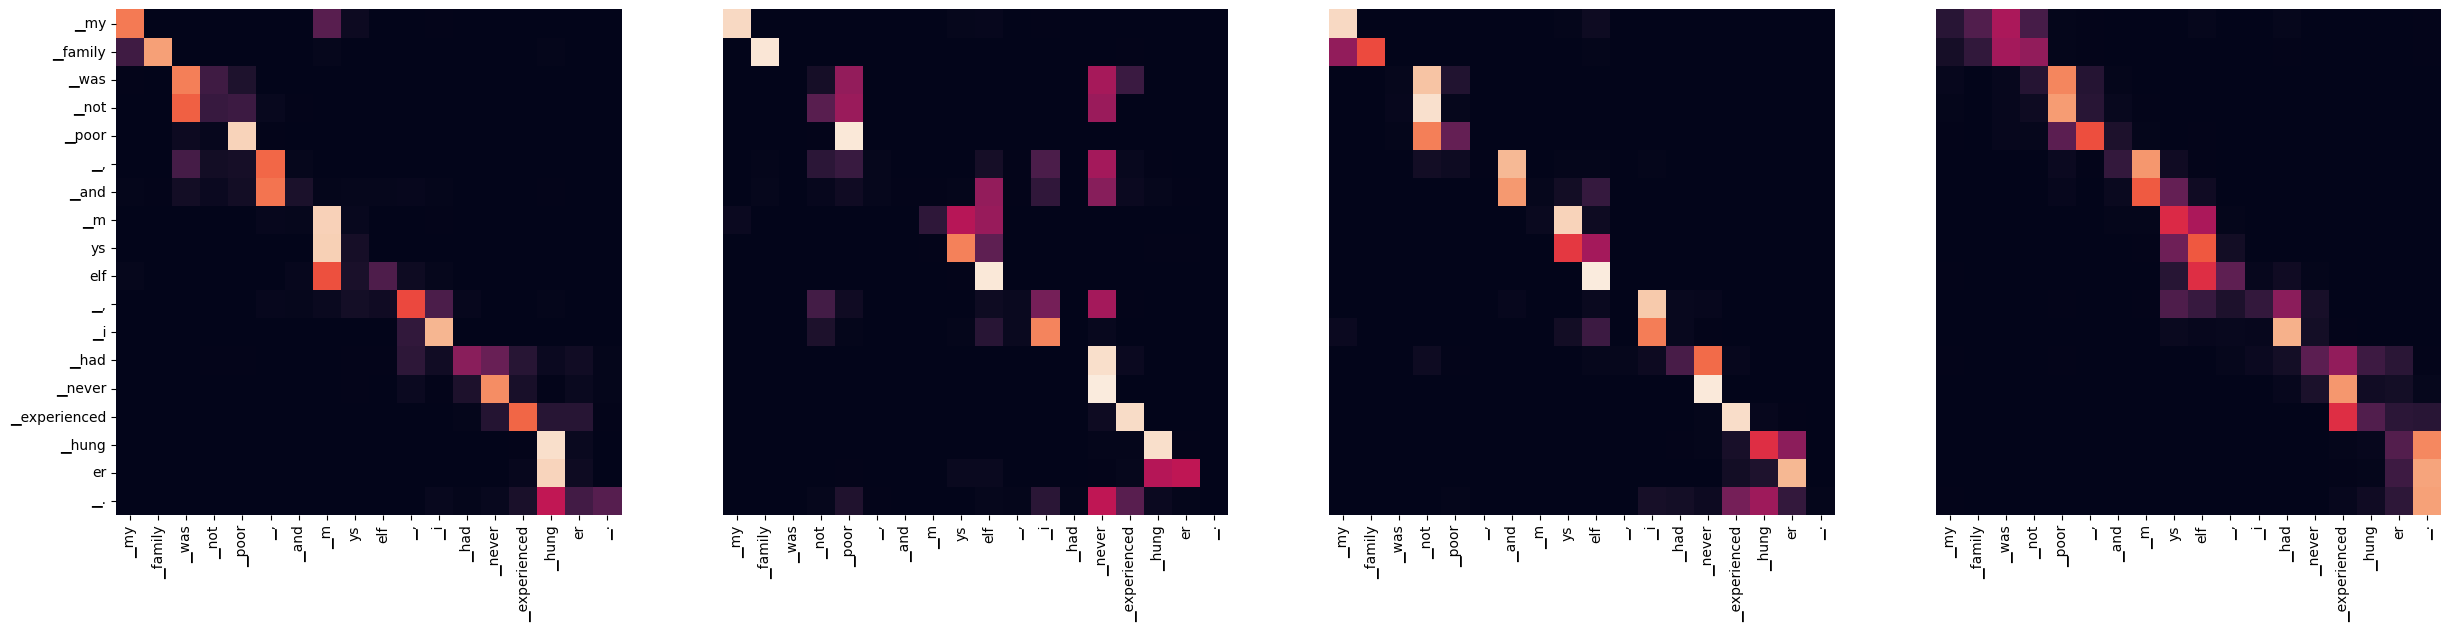

Encoder Layer 4


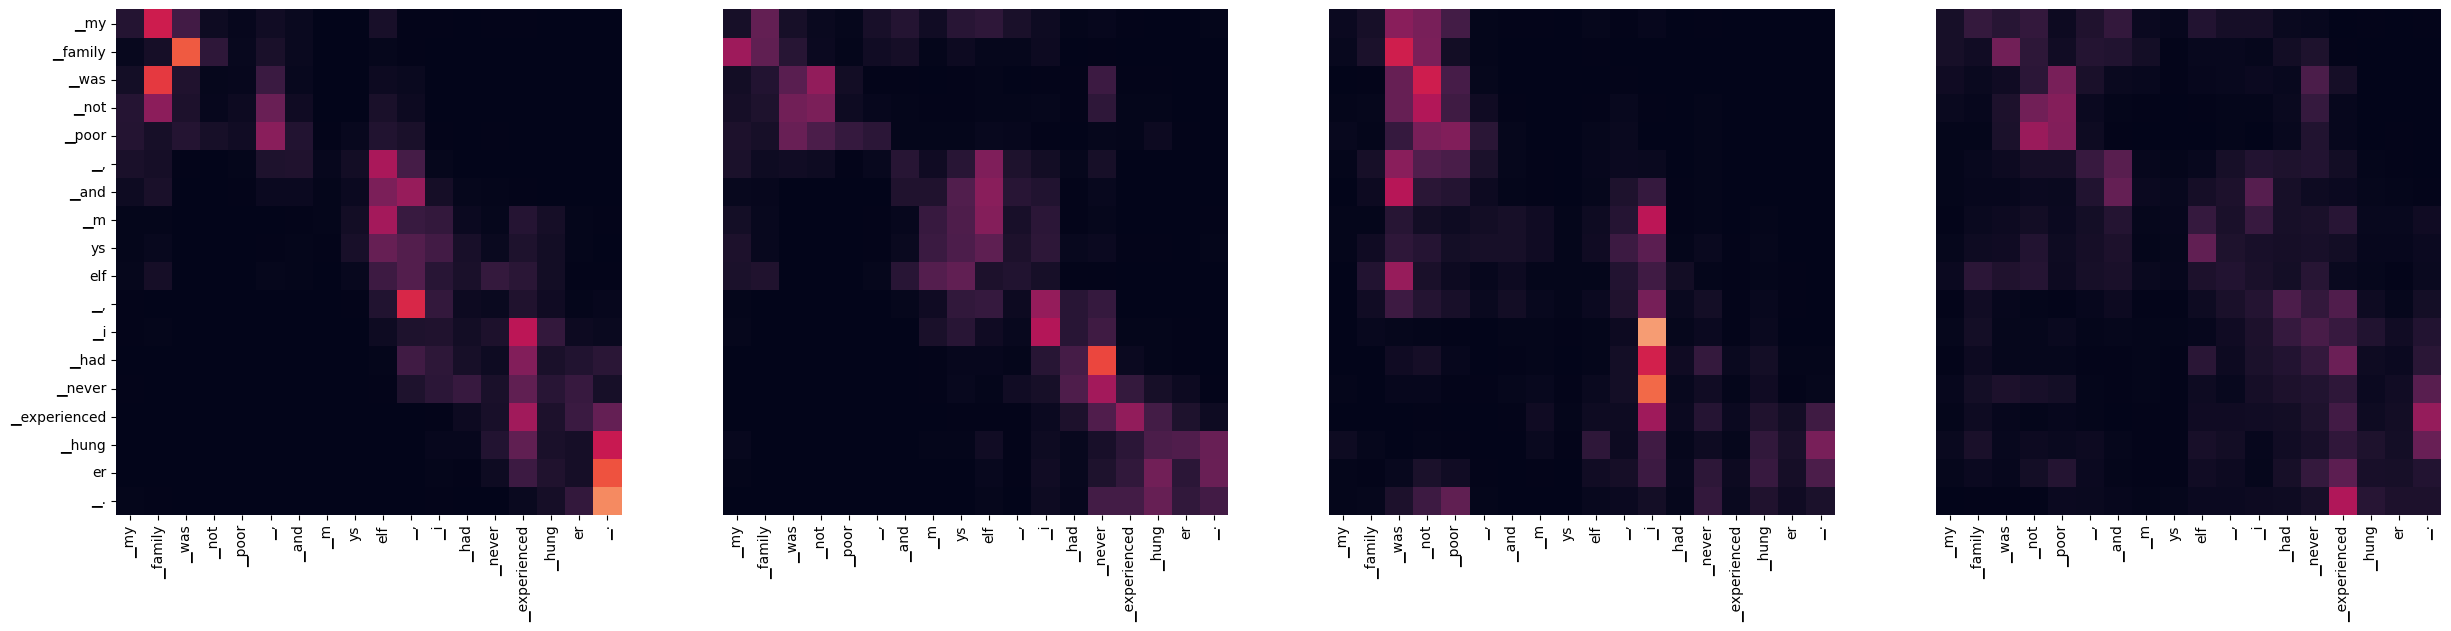

Encoder Layer 6


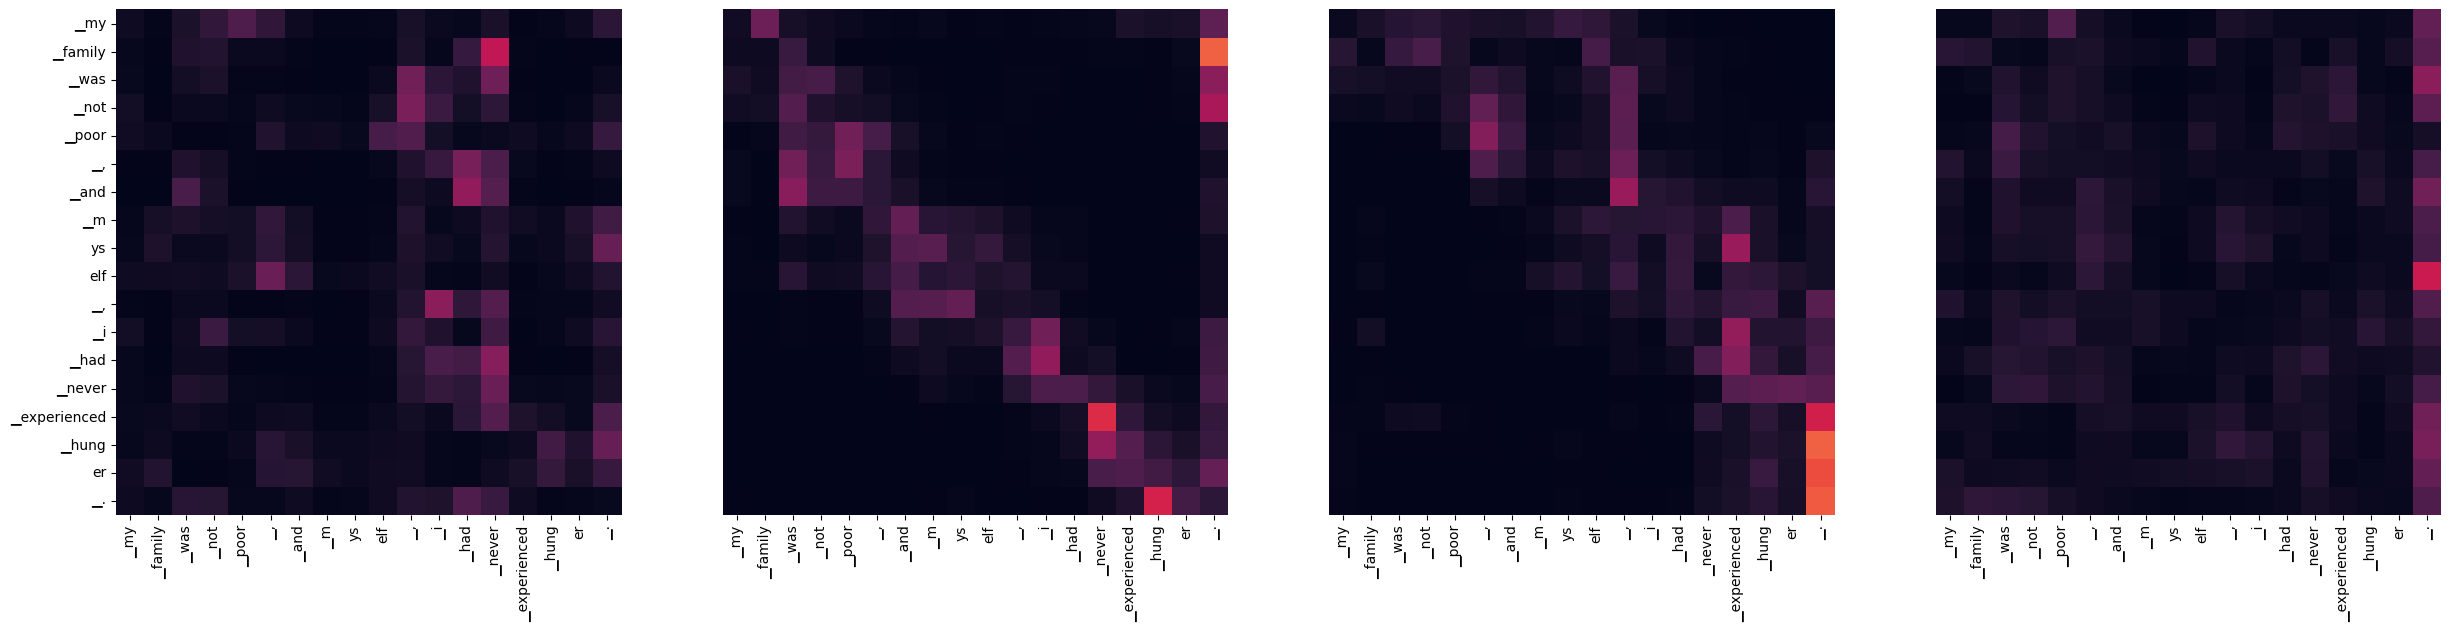

In [ ]:
sent = SRC.preprocess(sentence)

for layer in range(1, 6, 2):
    fig, axs = plt.subplots(1,4, figsize=(30, 15))
    print("Encoder Layer", layer+1)
    for h in range(4):
        draw(model.encoder.layers[layer].attn.attn[0, h].data.cpu(),
            sent, sent if h ==0 else [], ax=axs[h])
    plt.show()

# Visualize Decoder
Ở decoder, các bạn có 2 loại visualization
* self attention: giá trị attention khi mô hình decoder mã hóa câu đích lúc dịch
* src attention: giá trị attention khi mô hình decoder sử dụng câu src

Decoder Self Layer 2


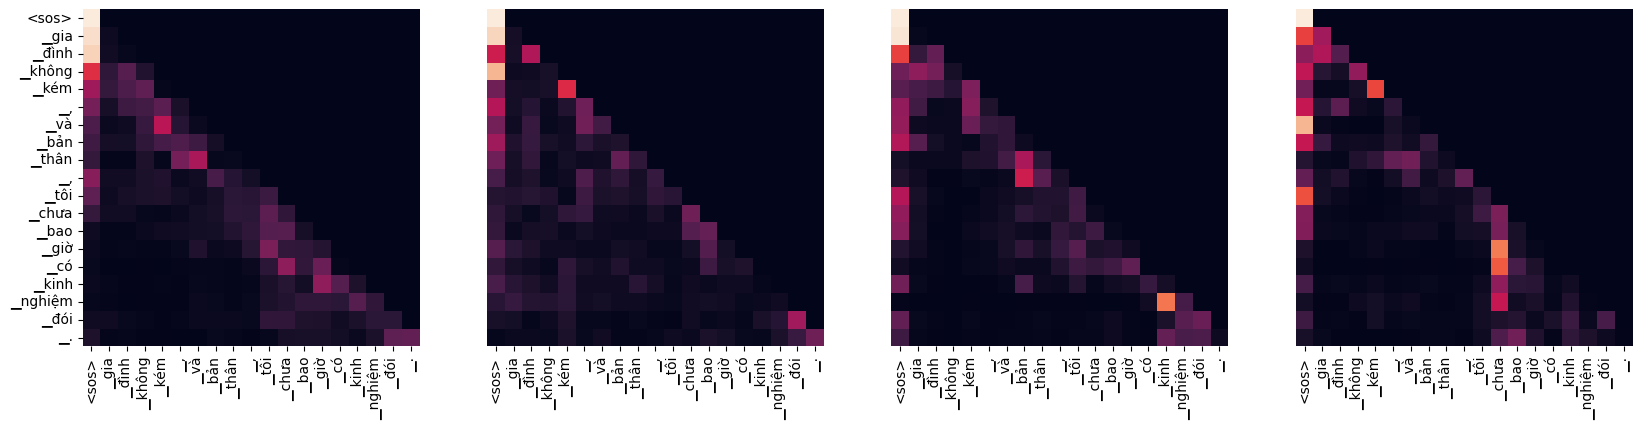

Decoder Src Layer 2


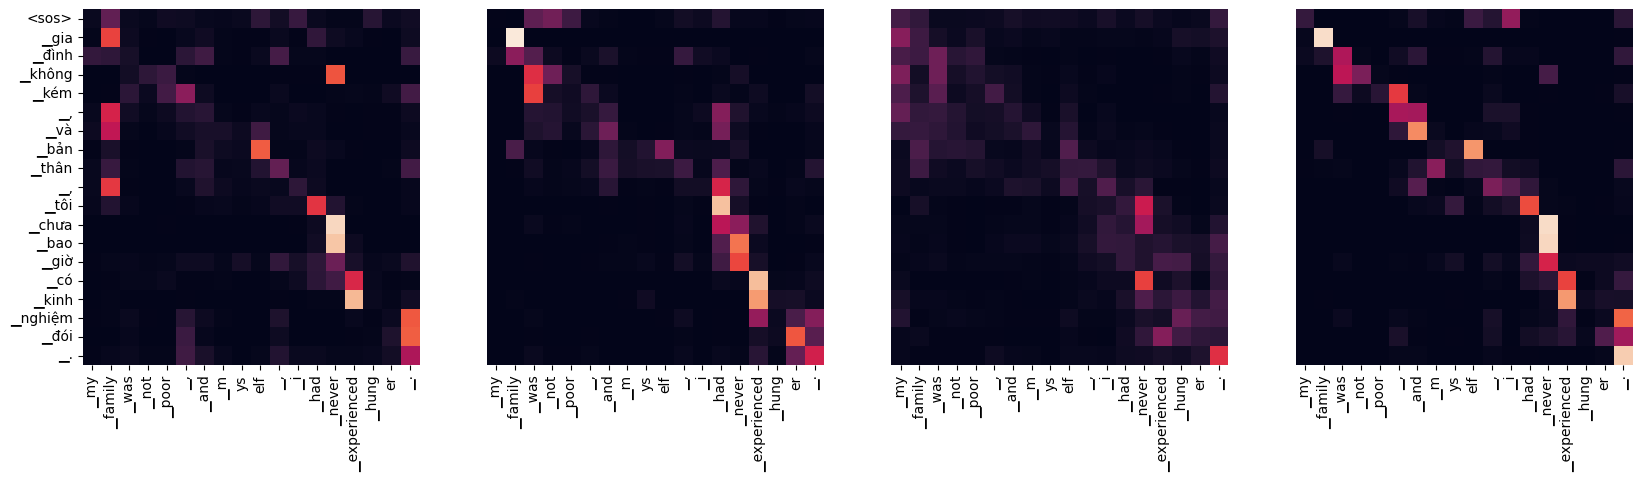

Decoder Self Layer 4


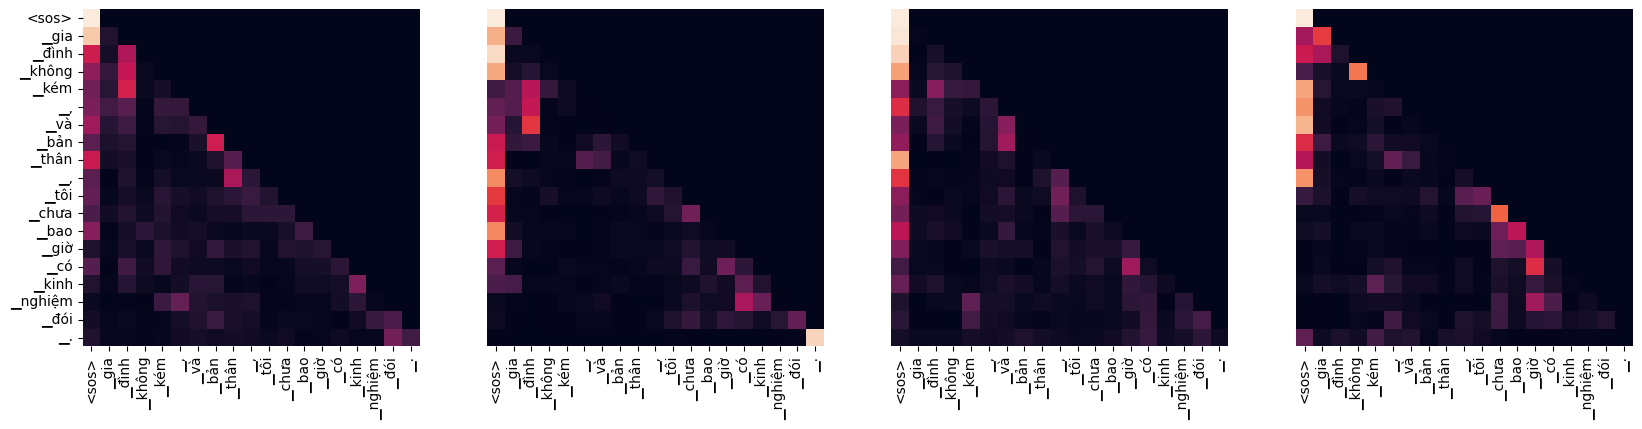

Decoder Src Layer 4


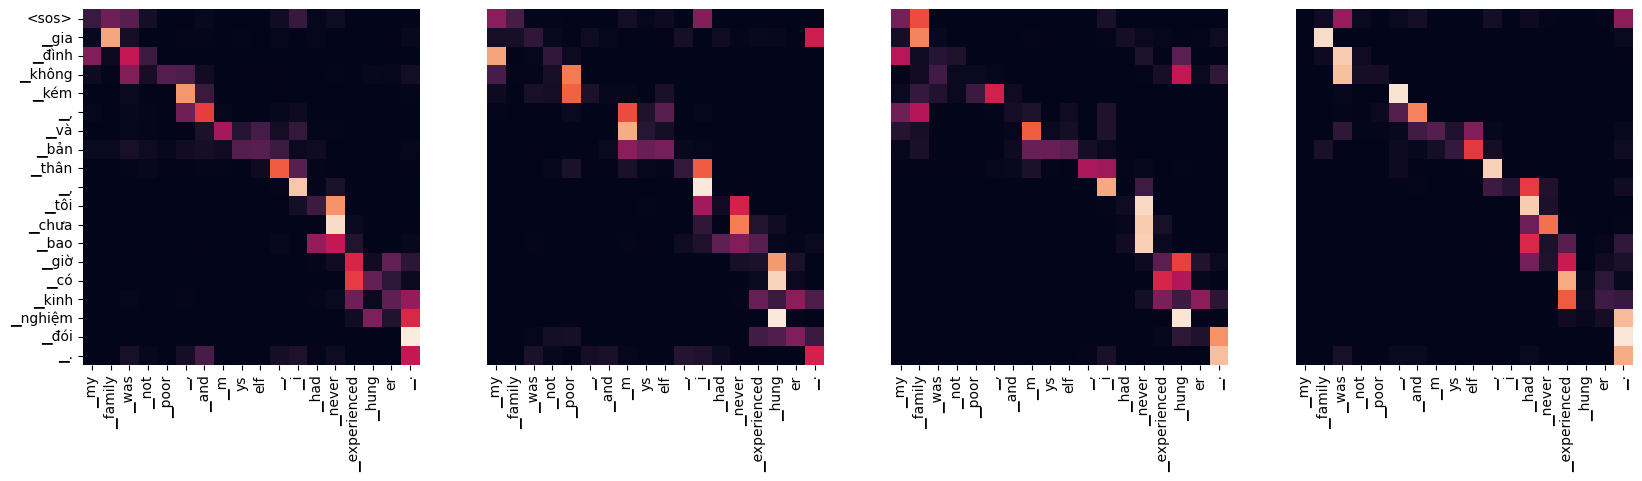

Decoder Self Layer 6


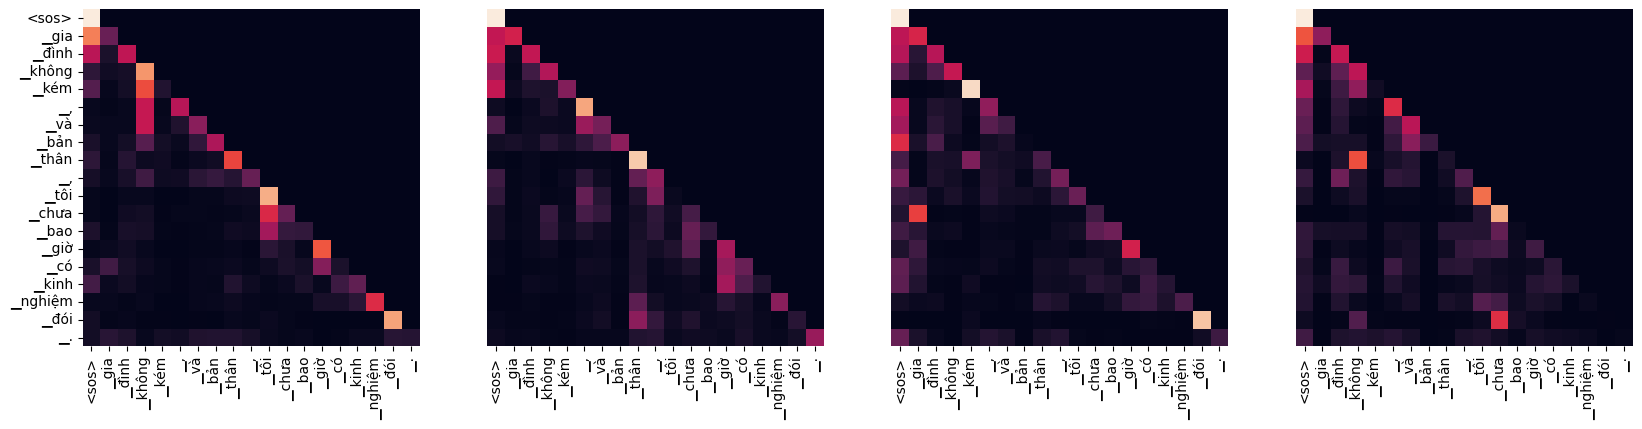

Decoder Src Layer 6


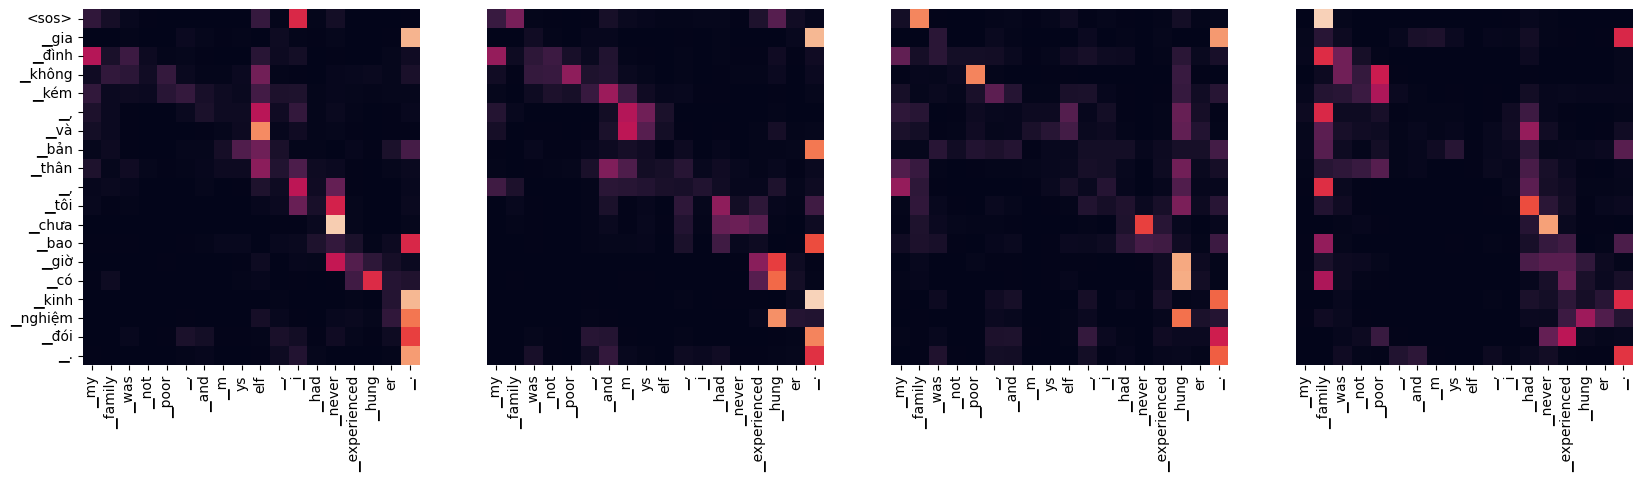

In [ ]:
trg_sent = ['<sos>'] + TRG.preprocess(trans_sent)

for layer in range(1, 6, 2):
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    print("Decoder Self Layer", layer+1)
    for h in range(4):
        draw(model.decoder.layers[layer].attn_1.attn[0, h].data[:len(trg_sent), :len(trg_sent)].cpu(),
            trg_sent, trg_sent if h ==0 else [], ax=axs[h])
    plt.show()
    print("Decoder Src Layer", layer+1)
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    for h in range(4):
        draw(model.decoder.layers[layer].attn_2.attn[0, h].data[:len(trg_sent), :len(sent)].cpu(),
            sent, trg_sent if h ==0 else [], ax=axs[h])
    plt.show()